In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from torch.utils.data import DataLoader
from dataset import CityscapesDataset
from tqdm import tqdm
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"🟢 Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("🟡 Using CPU")

# Parametri
batch_size = 4
num_classes = 19
epochs = 1
resize = (256, 512)

# Trasformazioni
transform = transforms.Compose([
    transforms.Resize(resize),
    transforms.ToTensor(),
])

# Dataset e DataLoader
train_dataset = CityscapesDataset(root='datasets/cityscapes', split='train', transform=transform, resize=resize)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count(),persistent_workers=True, pin_memory=True)

# Modello
model = deeplabv3_resnet50(pretrained=False, num_classes=num_classes).to(device)

start_epoch = 0
checkpoint_path = 'deeplabv3_cityscapes.pth'
if os.path.exists(checkpoint_path):
    print("🔁 Checkpoint trovato: ripristino stato del modello...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model'])
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint['epoch'] + 1
else:
    optimizer = optim.Adam(model.parameters(), lr=1e-4)


# Loss e ottimizzatore
criterion = nn.CrossEntropyLoss(ignore_index=255)

# Training loop
scaler = torch.cuda.amp.GradScaler()
for epoch in range(start_epoch, start_epoch + epochs):
    
    start = time.time()
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{start_epoch + epochs}")
    for images, masks in loop:
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        #print("UNIQUE LABELS IN BATCH:", torch.unique(masks))
        with torch.cuda.amp.autocast():
            outputs = model(images)['out']
            loss = criterion(outputs, masks)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() 

    elapsed = time.time() - start
    print(f"✅ Epoch {epoch+1}/{start_epoch+epochs} - Avg Loss: {running_loss/len(train_loader):.4f} - Time: {elapsed:.2f} sec")

# Salva il modello
torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'epoch': epoch
}, checkpoint_path)

🟢 Using GPU: NVIDIA GeForce RTX 4070
🔁 Checkpoint trovato: ripristino stato del modello...


C:\Users\colam\AppData\Local\Temp\ipykernel_27472\3434299119.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

🟢 Using GPU: NVIDIA GeForce RTX 4070


C:\Users\colam\AppData\Local\Temp\ipykernel_27472\1421718622.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


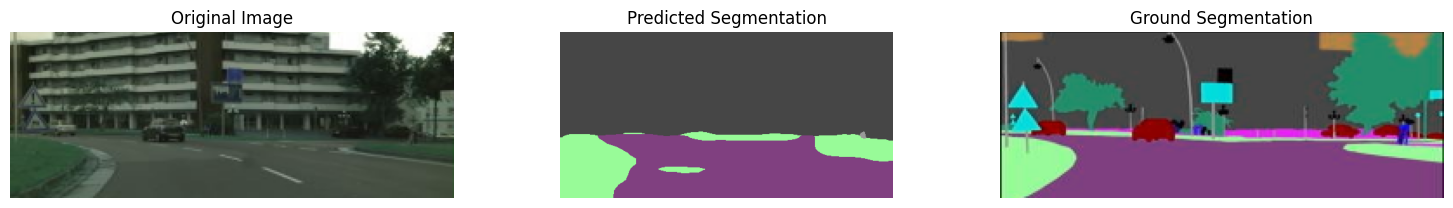

In [19]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from dataset import COLORS

# 🔧 Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"🟢 Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("🟡 Using CPU")

num_classes = 19
model_path = 'deeplabv3_cityscapes.pth'
image_path = 'datasets/cityscapes/train/img/train1.png'  
ground_image_path = 'datasets/cityscapes/train/label/train1.png' 
resize = (256, 512)  


def decode_segmap(pred):
    h, w = pred.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for label in range(num_classes):
        color_mask[pred == label] = COLORS[label]
    return color_mask

# 📦 Load model
model = deeplabv3_resnet50(pretrained=False, num_classes=num_classes).to(device)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model'])

model.eval()

# 🖼️ Load and preprocess image
image = Image.open(image_path).convert('RGB')
ground_image = Image.open(ground_image_path) 
original_size = image.size

transform = transforms.Compose([
    transforms.Resize(resize),
    transforms.ToTensor(),
])
input_tensor = transform(image).unsqueeze(0).to(device)

# 🔍 Inference
with torch.no_grad():
    output = model(input_tensor)['out']
    output = torch.nn.functional.interpolate(output, size=resize, mode='bilinear', align_corners=False)
    prediction = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
    seg_image = decode_segmap(prediction)

# 📊 Visualizzazione
plt.figure(figsize=(15, 4))
plt.subplot(2, 3, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title("Predicted Segmentation")
plt.imshow(seg_image)
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title("Ground Segmentation")
plt.imshow(ground_image)
plt.axis('off')

plt.tight_layout()
plt.show()
